In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

<AxesSubplot:xlabel='timestamp'>

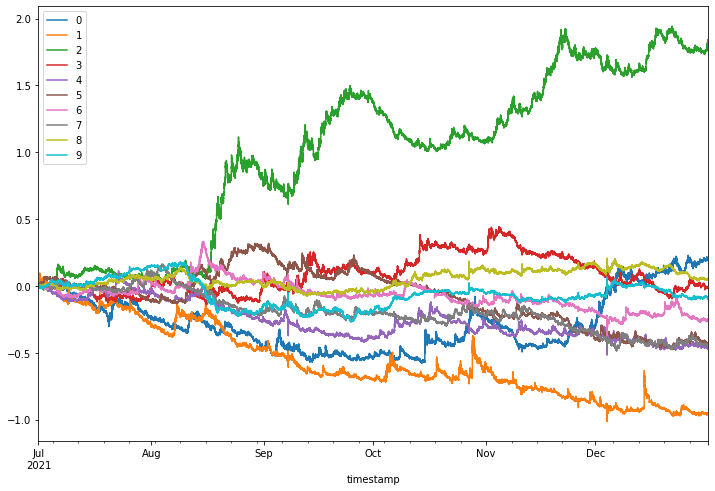

In [3]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

In [4]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [5]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

11.311692953109741


In [6]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [7]:
# Correlation for every asset

r_fwd.corrwith(r_hat)

0    0.028584
1    0.063681
2    0.005824
3    0.036314
4    0.096442
5    0.035261
6    0.067607
7    0.022329
8    0.105946
9    0.053176
dtype: float64

In [8]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]

0.04011869454104755